In [1]:
# Setup Distributed Client
autostart = True
if autostart:
    pass # just let it use the dask lab extension cluster
else:
    from dask.diagnostics import ProgressBar
    from dask.distributed import Client
    from dask.distributed import LocalCluster
    # client = Client('localhost:8787') # Connect to old dashboard?
    try:
        client = Client('tcp://localhost:8786', timeout='2s')
    except OSError:
        cluster = LocalCluster(scheduler_port=8786)
        client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:36076' processes=6 threads=24, memory=134.93 GB>

In [2]:
### Setup Packages
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
from xarray import open_mfdataset
import dask
import dask.array as da
import netCDF4 as netcdf
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import animation, rcParams, cycler
from matplotlib.animation import FuncAnimation
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import cartopy
import cartopy.crs as ccrs
import metpy
import metpy.calc as mpcalc
from metpy.units import units
import metpy.interpolate
import itertools
import scipy.spatial
import sklearn.metrics
from fractions import Fraction
import dateutil
import xrft


import sys
import os
from importlib import reload

sys.path.insert(1,r"/export/home1/jbenjami/Research_Thompson/Python/personal/")
print(sys.path)
import personal

import personal.math as pm
import personal.data_structures
import personal.date_operations
import personal.SMODE
import personal.calculations
import personal.geometry
import personal.system
import personal.plots
import personal.IO
import personal.constants
import personal.geospatial

from holoviews.operation.datashader import datashade, spread, rasterize
import holoviews
import geoviews


import personal.data_structures
import personal.plots
import finufft
# dir(finufft)
import matplotlib.pyplot as plt
import numpy as np



import gc; gc.collect()


a                = personal.constants.earth['radius']

file_path        = os.path.abspath(os.path.dirname(''))
data_relpath     = "../Data/HF_Radar/2km/processed/smode_region/"
output_savepath  = "../Data/HF_Radar/2km/processed/smode_region/miscellaneous/"
data_source      = os.path.normpath(os.path.join(file_path, data_relpath))


### Plot setup
dpi = 100
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
from matplotlib import animation, rcParams, cycler
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

['/export/home1/jbenjami/Research_Thompson/Python', '/export/home1/jbenjami/Research_Thompson/Python/personal/', '/export/home1/jbenjami/anaconda3/lib/python37.zip', '/export/home1/jbenjami/anaconda3/lib/python3.7', '/export/home1/jbenjami/anaconda3/lib/python3.7/lib-dynload', '', '/export/home1/jbenjami/.local/lib/python3.7/site-packages', '/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages', '/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/export/home1/jbenjami/.ipython']


In [5]:
file_path        = os.path.abspath(os.path.dirname(''))
data_relpath     = "../Data/HF_Radar/2km/processed/smode_region/"
output_savepath  = "../Data/HF_Radar/2km/processed/smode_region/miscellaneous/"
data_source      = os.path.normpath(os.path.join(file_path, data_relpath))

seasons          = {'DJF':[12, 1, 2],'JFM':[ 1, 2, 3],'FMA':[ 2, 3, 4],
                    'MAM':[ 3, 4, 5],'AMJ':[ 4, 5, 6],'MJJ':[ 5, 6, 7],
                    'JJA':[ 6, 7, 8],'JAS':[ 7, 8, 9],'ASO':[ 8, 9,10],
                    'SON':[ 9,10,11],'OND':[10,11,12],'NDJ':[11,12, 1]}

# velocity                = xr.open_mfdataset(data_source+'/velocity/*.nc*'      , decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override",parallel=True) # chunked this way for speed, since we are now just saving calcs to disk... decoding times seems to work, dask chunks for speed
kinetic_energy          = xr.open_mfdataset(data_source+'/kinetic_energy/*.nc*', decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override",parallel=True) # chunked this way for speed, since we are now just saving calcs to disk... decoding times seems to work, dask chunks for speed
KE                      = kinetic_energy #.drop(['u_p','v_p'])

# velocity_smoothed       = xr.open_mfdataset(data_source+'/smoothed/velocity/*.nc*'      , decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override",parallel=True) # chunked this way for speed, since we are now just saving calcs to disk... decoding times seems to work, dask chunks for speed
kinetic_energy_smoothed = xr.open_mfdataset(data_source+'/smoothed/kinetic_energy/*.nc*', decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override",parallel=True) # chunked this way for speed, since we are now just saving calcs to disk... decoding times seems to work, dask chunks for speed

KE_smoothed             = kinetic_energy_smoothed #.drop(['u_p','v_p'])
lat, lon, time          = KE['lat'], KE['lon'], KE['time']
latg,long               = np.meshgrid(lat,lon,indexing='ij') # 'ij' to match the shape of x,y
coords                  = np.float32(np.stack((latg.flatten(), long.flatten()),axis=1)) # check order (x,y matches lon,lat)
seas_groups             = {seas:time.dt.month.isin(months) for seas,months in seasons.items()}
#
moving_groups           = time.dt.strftime("%Y-%m")
yrmn_groups             = {x: moving_groups.isin(x) for x in np.unique(moving_groups)}

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
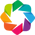

Row
    [0] Param(Data_Explorer, expand_button=False)
    [1] ParamMethod(method)

In [4]:
from cartopy import crs
reload(personal.plots)
# personal.plots.data_map_viewer(KE['KE'],projection=None)
groups = ('[u, v]', '[speed, KE]')
cmap_0 = LinearSegmentedColormap.from_list("mycmap", [[1,1,1],[0,0,.5],[0,.5,0],'yellow',[1,0,0],'pink'],N=250)

personal.plots.data_map_viewer({groups[0]:velocity[['u','v']], groups[1]:velocity[['speed','KE']]  }, projection=None,clim={groups[0]:(-.3,.3),groups[1]:(0,.3)}, cmap = {groups[0]:None,groups[1]:cmap_0},  plot_coasts=True)

In [5]:
# Take section w/ MetPy
# section = [[35,360-122],[39,360-126]] # good test
section = [[lat[0].values,lon[-1].values], [lat[-1].values,lon[0].values]]
KE_slice = metpy.interpolate.cross_section(KE, section[0], section[1],steps=500).set_coords(('lat', 'lon'))

coords   = np.vstack((KE_slice.lat.values,KE_slice.lon.values)).T
lc       = len(coords)
dxs      = np.array([sklearn.metrics.pairwise.haversine_distances(np.radians(coords[i:i+2]))[0,1]*a for i in range(lc-1)])
dx       = np.mean(dxs)
x        = 0 + np.arange(lc)*dx
KE_Slice = KE_slice.swap_dims({'index':'x'}).assign_coords({'x':x}).drop(['lat','lon','index'])['KE']

In [6]:
# Calculate slice w/ mirroring 
KE_flipped  = KE_Slice.reindex(x=list(reversed(KE_Slice.x))).assign_coords({'x':np.hstack( (np.flip(-np.arange(lc+1)*dx)[:-1]))})
KE_mirrored = xr.concat([KE_flipped,KE_Slice], dim='x')
KE_Slice = KE_mirrored
# KE_mirrored.plot()

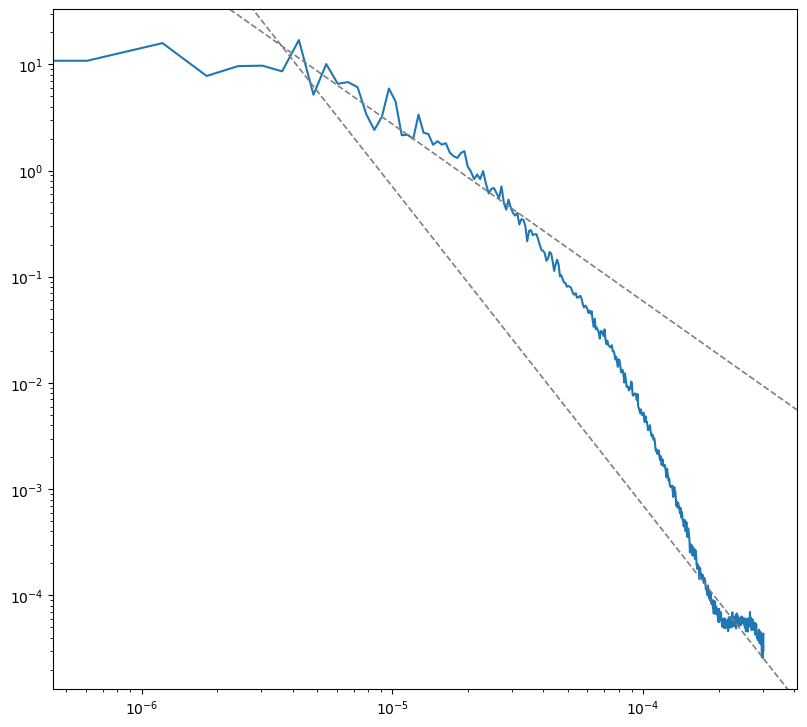

In [10]:
# Calculate Power Spectrum
uhat2 = xrft.power_spectrum(KE_Slice, dim=['x'], detrend='constant', window=True,shift=False).compute().isel({'freq_x':[*range(len(KE_Slice['x'])//2)]})
fig = personal.plots.default_figure()
_ax = plt.axes()
_ax.set_xscale('log')
_ax.set_yscale('log')
k = uhat2.freq_x.values
E = uhat2.mean('time').values
_ax.plot(k, E )
slope = Fraction(-5,3); personal.plots.axline(_ax, slope=float(slope),ax_scale='loglog',intercept=[k[15], E[15]]  , color='gray'    ,linestyle='--',label='slope = ' + str(slope), linewidth=1.2)
slope = Fraction(-9,3); personal.plots.axline(_ax, slope=float(slope),ax_scale='loglog',intercept=[k[-5], E[-5]]  , color='gray'    ,linestyle='--',label='slope = ' + str(slope), linewidth=1.2)

In [13]:
# Calculate Power Spectrum by season
outputs = {}
for j,seas in enumerate(seasons):
    print('season: ' + seas)
    outputs[seas] = xrft.power_spectrum(KE_Slice[time_groups[seas]], dim=['x'], detrend='constant', window=False,shift=False).compute().isel({'freq_x':[*range(len(KE_Slice['x'])//2)]}) # should i detrend? should i window?

season: DJF
season: JFM
season: FMA
season: MAM
season: AMJ
season: MJJ
season: JJA
season: JAS
season: ASO
season: SON
season: OND
season: NDJ


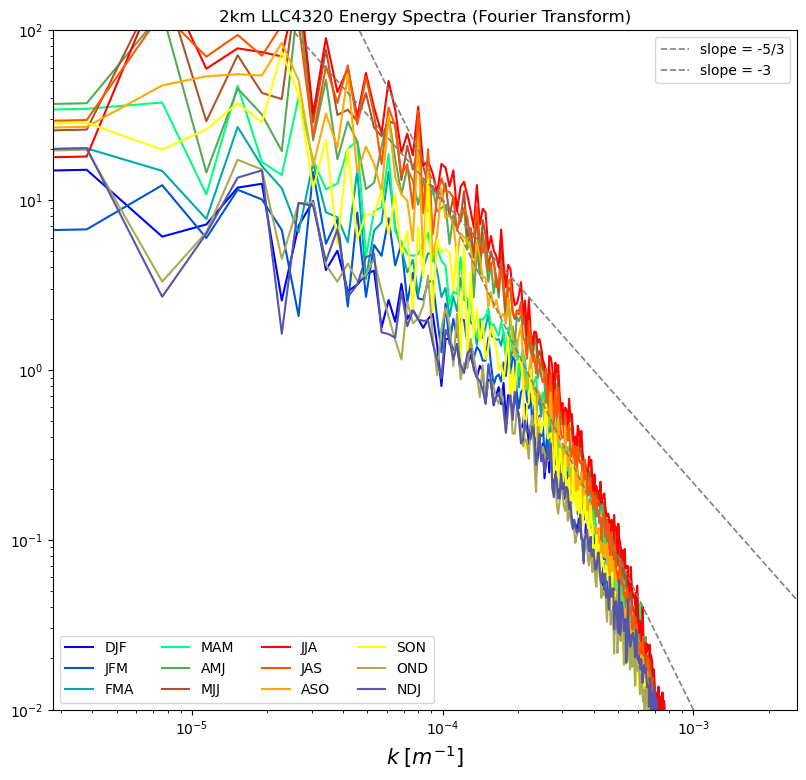

In [14]:
fig = personal.plots.default_figure()
_ax  = plt.axes()
_ax.set_xscale('log');  
_ax.set_yscale('log');
cmap = LinearSegmentedColormap.from_list("mycmap", [[0,0,1],[0,1,.5],[1,0,0],'yellow',[0,0,1]],N=13)
colors = cmap(np.linspace(0, 1, 13)[0:12])
for seas, color in zip(seasons.keys(),colors):
    k = outputs[seas].freq_x.values * (2*np.pi)
    E = outputs[seas].mean('time').values
    _ax.plot(k,E, color=color, label=seas) #logx=True,logy=True,label=seas,c=color)
_ax.set_xlabel(r"$k\; [m^{-1}]$", fontsize=15)
_ax.set_title('2km LLC4320 Energy Spectra (Fourier Transform)')
_ax.set_ylim([1e-2, 1e2]);

slope = Fraction(-5,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[1e-4,1e+1]  , color='gray'    ,linestyle='--',label='slope = ' + str(slope), linewidth=1.2)
slope = Fraction(-9,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[1e-4,1e+1]  , color='gray'    ,linestyle='--',label='slope = ' + str(slope), linewidth=1.2)
leg  = _ax.get_legend_handles_labels()
leg1 = _ax.legend(leg[0][ 0:12], leg[1][ 0:12], loc='lower left'  ,ncol=4)
_    = _ax.legend(leg[0][12:  ], leg[1][12:  ], loc='upper right' ,ncol=1)
_    = _ax.add_artist(leg1)

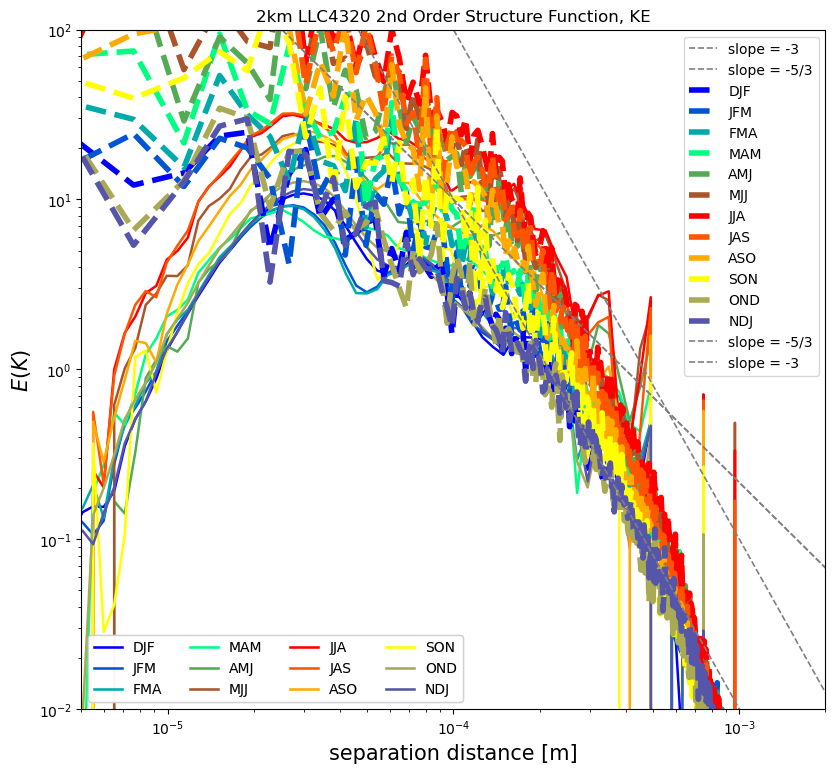

In [15]:
fig = personal.IO.pickle_load( '../Figures/test_fig_E_hankel.o')
_ax = fig.axes[0]
  
# _ax.set_yscale('linear');
cmap = LinearSegmentedColormap.from_list("mycmap", [[0,0,1],[0,1,.5],[1,0,0],'yellow',[0,0,1]],N=13)
colors = cmap(np.linspace(0, 1, 13)[0:12])
for seas, color in zip(seasons.keys(),colors):
    k = outputs[seas].freq_x.values * (2*np.pi)
    E = outputs[seas].mean('time').values
    _ax.plot(k,E*2, color=color, label=seas,linewidth=4, linestyle='--') #logx=True,logy=True,label=seas,c=color)
_ax.set_xlabel('separation distance [m]')
_ax.set_title('2km LLC4320 2nd Order Structure Function, KE')

slope = Fraction(-5,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[1e-4,1e+1]  , color='gray'    ,linestyle='--',label='slope = ' + str(slope), linewidth=1.2)
slope = Fraction(-9,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[1e-4,1e+1]  , color='gray'    ,linestyle='--',label='slope = ' + str(slope), linewidth=1.2)
leg  = _ax.get_legend_handles_labels()
leg1 = _ax.legend(leg[0][ 0:12], leg[1][ 0:12], loc='lower left',ncol=4)
_    = _ax.legend(leg[0][12:  ], leg[1][12:  ], loc='upper right' ,ncol=1)
_    = _ax.add_artist(leg1)
fig

In [1]:
fig = personal.IO.pickle_load( '../Figures/test_fig_E_hankel.o')


NameError: name 'personal' is not defined

In [ ]:
k = outputs[seas].freq_x.values[1:] * (2*np.pi) # cut off the 0 value

# Plot cycles for various ks
reload(personal.data_structures)
n = 25
# ks = np.logspace( np.log10(np.min(k)), np.log10(np.max(k)), n )
ks = np.linspace(np.min(k), np.max(k), n )

xt = np.array([np.datetime64(x) for x in dateutil.rrule.rrule(freq=dateutil.rrule.MONTHLY, count=12, dtstart=datetime.datetime(1, 1, 15))])
fig = personal.plots.default_figure()
_ax = plt.axes()

_ax.set_xlim(xmin=np.datetime64('0001-01-01'),xmax=np.datetime64('0002-01-01'))
_ax.xaxis.set_major_locator(mdates.MonthLocator())
_ax.xaxis.set_major_formatter( FuncFormatter(lambda x,pos: mdates.DateFormatter('#b')(x)[0] ))
ks_nearest, ksn_inds = personal.data_structures.nearest(ks, k)
lc = len(ks)+1
cmap_here   = LinearSegmentedColormap.from_list("mycmap", [[1,0,0],[0,0,1]],N=lc)
colors_here = cmap_here(np.linspace(0, 1, lc)[0:lc-1])
for i,ind in enumerate(ksn_inds):
    E = np.array([outputs[seas].mean('time').values[ind] for seas in seasons.keys()])
#     E = np.array([outputs[seas]['E'][eq][ind] for seas in seasons.keys()])
    _ax.plot(xt,E,color = colors_here[i], label=f"{ks_nearest[i]:.2E}" )
leg = _ax.legend(loc='upper center',ncol=6, bbox_to_anchor=(.5, -0.05))
_ax.set_yscale('log')   ; _ax.set_ylim([1e-4, 1.0e2]);
# _ax.set_yscale('linear'); _ax.set_ylim([1e-1, 3.5e1]);


# fig2 = personal.plots.default_figure()
# _ax2 = plt.axes()
# _ax2.set_xlim(xmin=np.datetime64('0001-01-01'),xmax=np.datetime64('0002-01-01'))
# _ax2.xaxis.set_major_locator(mdates.MonthLocator())
# _ax2.xaxis.set_major_formatter( FuncFormatter(lambda x,pos: mdates.DateFormatter('#b')(x)[0] ))
# n = 30
# ks                   = np.logspace( np.log10(np.min(r_in)), np.log10(np.max(r_in)), n )[3: -2]
# ks_nearest, ksn_inds = personal.data_structures.nearest(ks, outputs['DJF'][engine]['k'][eq])
# lc = len(ks)+1
# cmap_here   = LinearSegmentedColormap.from_list("mycmap", [[1,0,0],[0,0,1]],N=lc)
# colors_here = cmap_here(np.linspace(0, 1, lc)[0:lc-1])
# for i,ind in enumerate(ksn_inds):
#     E = np.array([outputs[seas][engine]['E'][eq][ind] for seas in seasons.keys()])
# #     E = sklearn.preprocessing.minmax_scale(E,feature_range=(0,1),copy=True)
#     E = sklearn.preprocessing.minmax_scale(np.log10(E),feature_range=(0,1),copy=True)
#     _ax2.plot(xt,E,color = colors_here[i], label=f"{ks_nearest[i]:.2E}" )
# leg = _ax2.legend(loc='upper center',ncol=6, bbox_to_anchor=(.5, -0.05))
# # _ax2.set_yscale('log')   ; _ax2.set_ylim([1e-1, 7.0e1]);
# _ax2.set_yscale('linear'); _ax2.set_ylim([1e-1, 3.5e1]);
# _ax2.set_ylim([0,1])

In [8]:
import personal.data_structures
import personal.plots
import finufft
# dir(finufft)
import matplotlib.pyplot as plt
import numpy as np

In [25]:
c = finufft.nufft1d2(x_scaled.squeeze(),fk.squeeze());    # evaluate Fourier series at x
c.shape

In [31]:
plt.plot(fk)

In [116]:
L = 10;             # period
kmax = 500;         # bandlimit
# k = -kmax:kmax-1;   # freq indices (negative up through positive mode ordering)
k = np.atleast_2d(np.arange(-kmax,kmax,1)).T
N = 2*kmax;         # # modes
# rng(0);             # make some convenient Fourier coefficients... (initialize a random number generator)
# fk = np.random.randn(N,1)+1j*np.random.randn(N,1);       # iid random complex data, column vec
fk = np.sin(4 * np.linspace(k[0],k[-1],N,endpoint=True)/kmax) #+ 0j
k0 = 100;           # a freq scale parameter
# fk = fk * np.exp(-(k/k0)**2)        # scale the amplitudes, kills high freqs

M = int(1e3);
x = L*np.random.rand(M);        # make random target points in [0,L)
tol = 1e-12;
x_scaled = x * (2*np.pi/L);         # don't forget to scale to 2pi-periodic!
# c = finufft.nufft1d2(x_scaled,+1,tol,fk);    # evaluate Fourier series at x
# c = finufft.nufft1d2(x_scaled,fk);    # evaluate Fourier series at x
# c = finufft.nufft1d2(x_scaled.squeeze(),fk.squeeze());    # evaluate Fourier series at x
c = finufft.nufft1d2(x_scaled.squeeze(),fk.squeeze(), 100);    # evaluate Fourier series at x

                                                                 
# Mp = int(1e4);               # how many pts to plot
# jplot = np.arange(1,Mp,1)  # indices to plot
fig,_ax = personal.plots.default_figure(facecolor='white'), plt.axes()
plt.plot(x,np.real(c),'b.');
# axis tight;
_ax.set_xlabel('x');
_ax.set_ylabel('Re f(x)');

AttributeError: 'int' object has no attribute 'dtype'

In [66]:
plt.figure(figsize=(25,5))
plt.scatter(x[::1],c[::1]*w[::1])
order = np.argsort(x)
plt.figure(figsize=(25,5))
plt.plot(x[order],c[order])

/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


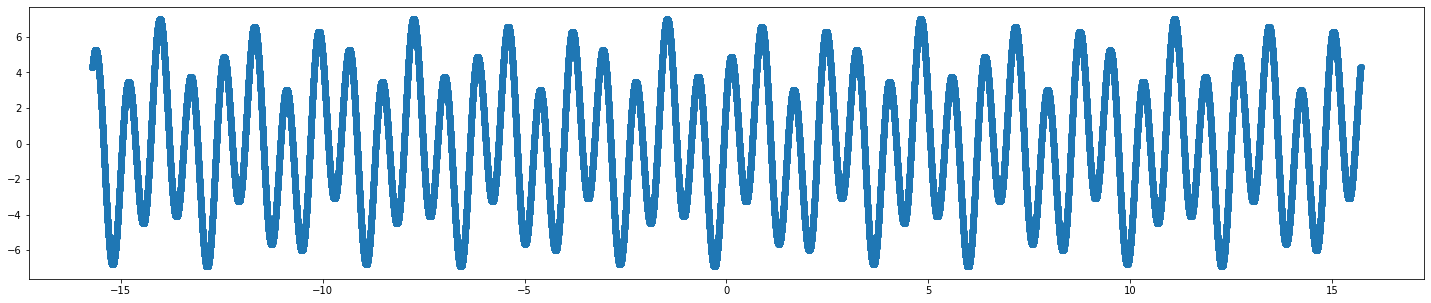

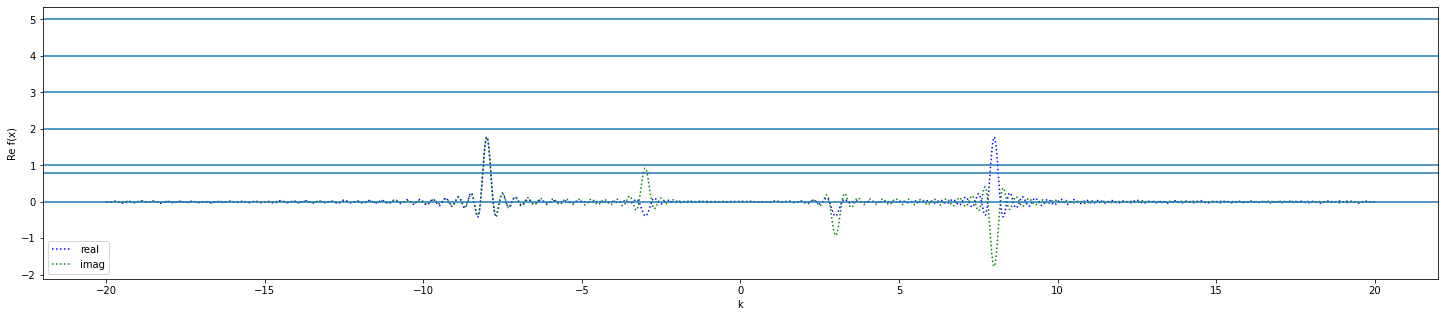

In [1035]:
# number of nonuniform points
# M = 100000
M = 100000

# the nonuniform points
x = 10 * np.pi * (np.random.uniform(size=M)-.5)
w = np.polynomial.legendre.legweight(x)
c = 2*np.sin(3 * x - np.pi/8) + 5*np.sin(8 * x + 1*np.pi/4) 


# x = np.random.uniform(-5,5,M)
# c = lambda x: np.cos(50*x**2);        # our smooth function defined on (a,b), zero elsewhere
# c = (np.abs(x) <1) * 1.

plt.figure(figsize=(25,5))
plt.scatter(x,c)
plt.show()

# desired number of Fourier modes (uniform outputs)
N = 100000

kmax = 20;                                            # half the side length in k
dk   = 2*kmax/N;              # spacing of target k grid
k    = dk * np.arange(-N/2,(N/2),1);    # a particular uniform M-grid of this spacing

# calculate the transform
# f = finufft.nufft1d1(x, c, N)
# calculate the transform to higher accuracy
# < type 1: (nonuniform to uniform)
# < type 2: (uniform to nonuniform)
# < type 3: (nonuniform to nonuniform)
# < type 4: just use fft for uniform to unform :)

fw = finufft.nufft1d1(dk * x , c*w, n_modes=N, eps=1e-12, isign=-1) # 1d type 1 (nonuniform to uniform)

f = finufft.nufft1d1(dk * x , c, n_modes=N, eps=1e-12,isign=-1)
# f = f / (dk*np.sum(f))
# f = f * (dk*np.pi)
f = f/(M)

fig,_ax = plt.figure(figsize=(25,5),facecolor='white'), plt.axes()
_ax.plot(k,np.real(f) ,color='b',linestyle='dotted', label='real');
# _ax.plot(k,np.real(fw),color='cyan',linestyle='dotted');

_ax.plot(k,np.imag(f),color='g',linestyle='dotted',label='imag');
# _ax.plot(k,np.abs(f) ,color='r',linewidth=1,linestyle='dotted',label='abs');
_ax.legend()

_ax.axhline(0)
_ax.axhline(1)
_ax.axhline(2)
_ax.axhline(3)
_ax.axhline(4)
_ax.axhline(5)
_ax.axhline(np.pi/4)

# axis tight;
_ax.set_xlabel('k');
_ax.set_ylabel('Re f(x)');
# _ax.set_xlim([0,20])

/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


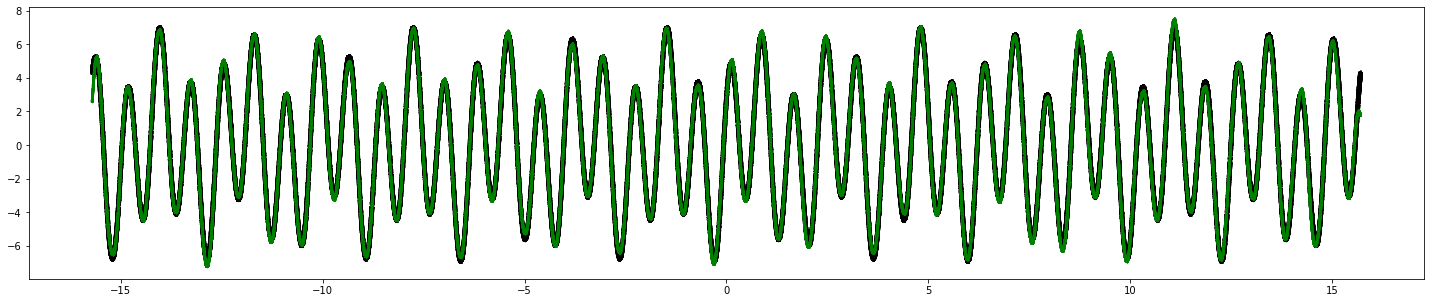

In [1036]:
# x = L*rand(1,M);        # make random target points in [0,L)
# x_scaled = x * (2*np.pi/L);         # don't forget to scale to 2pi-periodic!
# k_scaled = k/(np.max(k))
f_in = np.real(f)*1 + np.imag(f)*1j

f_reconstructed = finufft.nufft1d3(k,f_in,x,eps=1e-12,isign=+1);   # evaluate Fourier series at x
# f_reconstructed = f_reconstructed/(np.ptp(x)**1) / np.pi 
# f_reconstructed = f_reconstructed/(N**.5)
normalization = np.mean(np.abs(f_reconstructed))/np.mean(np.abs(c))
f_reconstructed = f_reconstructed / normalization


fig,_ax = plt.figure(figsize=(25,5),facecolor='white'), plt.axes()
_ax.scatter(x,c,15,color='k',linestyle='dotted',label='imag');
_ax.scatter(x,f_reconstructed,5,color='g',linestyle='dotted',label='imag');

[1.19212490e-02 4.81857217e+01]


(0.0, 29293.290809922055)

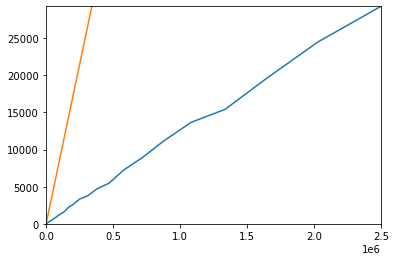

In [820]:
Ns = np.geomspace(90,2500000,50)
ln = len(Ns)
out = np.empty(Ns.shape)
for i,N in enumerate(Ns):
    N = int(N)
#     print(N)
    # number of nonuniform points
    M = 20000

    # the nonuniform points
    x = 10 * np.pi * (np.random.uniform(size=M)-.5)
    w = np.polynomial.legendre.legweight(x)
    c = 2*np.sin(3 * x - np.pi/8) #+ 5*np.sin(8 * x + 1*np.pi/4) 
    # desired number of Fourier modes (uniform outputs)
    # N = 50000

    kmax = 20;                                            # half the side length in k
    dk   = 2*kmax/N;              # spacing of target k grid
    k    = dk * np.arange(-N/2,(N/2),1);    # a particular uniform M-grid of this spacing
    fw = finufft.nufft1d1(dk * x , c*w, n_modes=N, eps=1e-12, isign=-1) # 1d type 1 (nonuniform to uniform)

    f = finufft.nufft1d1(dk * x , c, n_modes=N, eps=1e-12,isign=-1)
    f = f/(M)
    # s
    f_in = np.real(f)*1 + np.imag(f)*1j
    f_reconstructed = finufft.nufft1d3(k,f_in,x,eps=1e-12,isign=+1);   # evaluate Fourier series at x
    # f_reconstructed = f_reconstructed/(np.ptp(x)**1) / np.pi 
#     f_reconstructed = f_reconstructed/(N**.5)

    out[i] = np.max(np.abs(f_reconstructed))

fit = np.polyfit(Ns,out,1)
print(fit)

fig,_ax = plt.figure(),plt.axes()
plt.plot(Ns,out)
plt.plot(Ns,Ns*(4*np.pi/np.linalg.norm(np.imag(f))))
_ax.set_xlim([0,max(Ns)])
_ax.set_ylim([0,max(out)])


/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  
/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  import sys
/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y

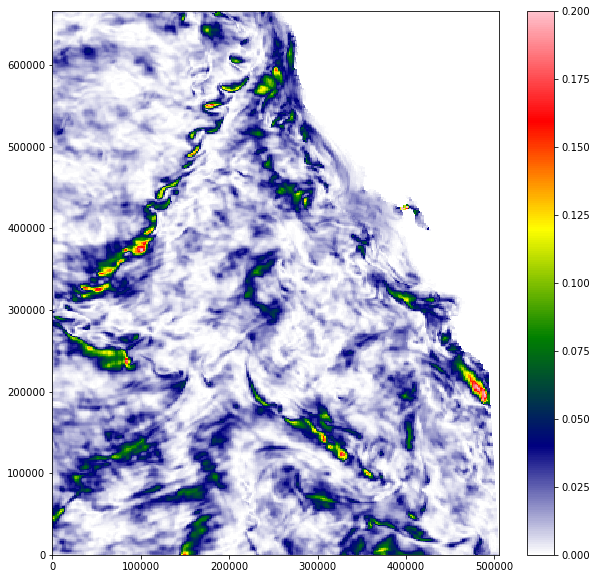

In [120]:
test_data_struct = KE['KE'][100].sel(baseline='all').compute()
dims={'t':0,'y':1,'x':2}
dx, dy = mpcalc.lat_lon_grid_deltas(test_data_struct.lon.values,test_data_struct.lat.values) # we havent the degrees east metadata to rely on :/, so gotta load values
dx = np.expand_dims(dx,0)
dy = np.expand_dims(dy,0)
y  = pm.dq_to_q(np.array(dy),dims['y'])[0]
x  = pm.dq_to_q(np.array(dx),dims['x'])[0]

test_data = test_data_struct.values
test_data_in,x_in,y_in = test_data.ravel(), x.ravel(), y.ravel()
valid = ~np.isnan(test_data_in)
test_data_in, x_in, y_in = test_data_in[valid].astype(np.float32), x_in[valid].astype(np.float32), y_in[valid].astype(np.float32)

cmap_0 = LinearSegmentedColormap.from_list("mycmap", [[1,1,1],[0,0,.5],[0,.5,0],'yellow',[1,0,0],'pink'],N=250)
plt.figure(figsize=(10,10))
plt.pcolormesh(x,y,test_data,cmap=cmap_0)
plt.colorbar()
plt.clim(0,.2)


In [76]:
# desired number of Fourier modes (uniform outputs)
M = 100000
N = 10000

kmax = 2e-3;                                            # half the side length in k
dk   = 2*kmax/N;              # spacing of target k grid
k    = dk * np.arange(-N/2,(N/2),1);    # a particular uniform M-grid of this spacing

f = finufft.nufft2d1(dk * x_in ,dk*y_in, test_data_in, n_modes=N, eps=1e-12, isign=-1) # 1d type 1 (nonuniform to uniform)

/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/finufft/_interfaces.py:387: Warning: FINUFFT eps tolerance too small to achieve
  warnings.warn(err_msg, Warning)


/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if sys.path[0] == '':
/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C

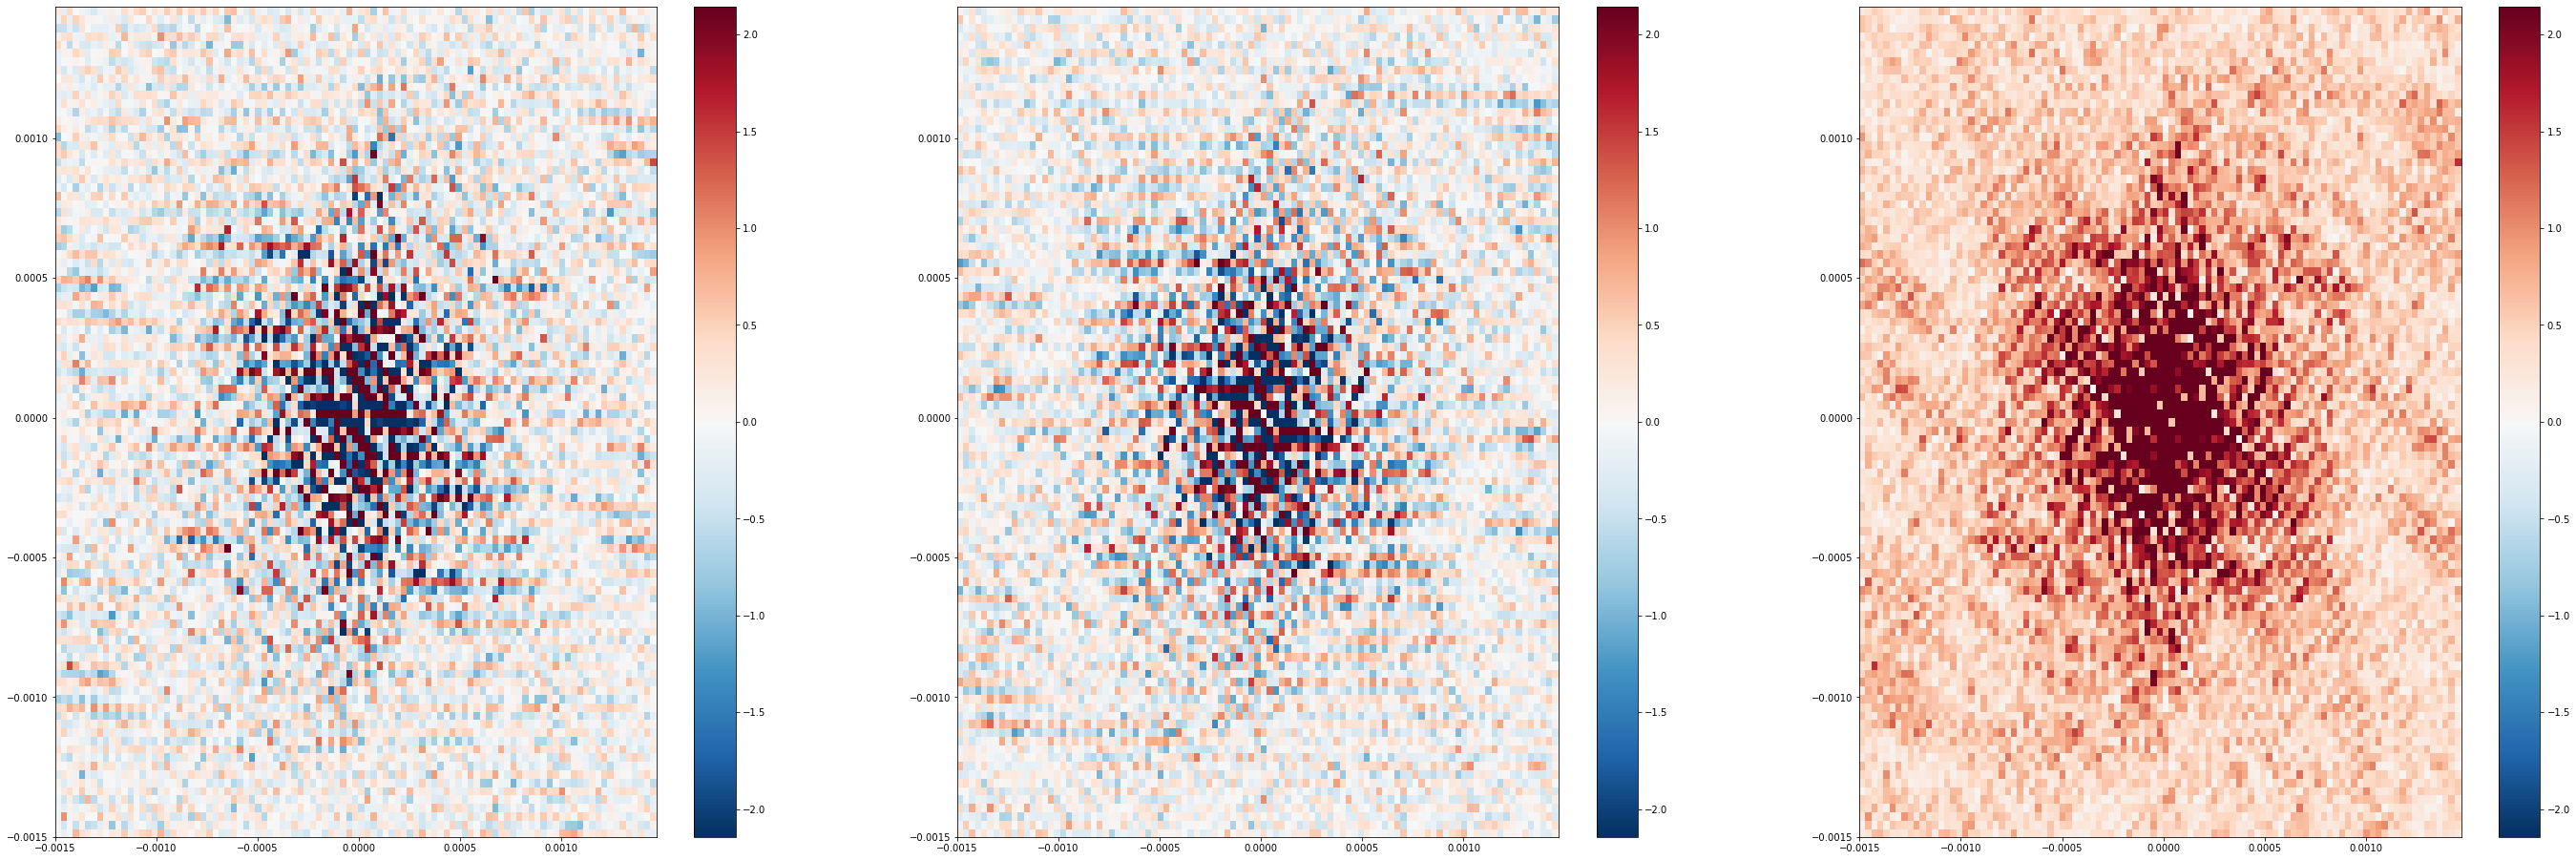

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(48,16),facecolor='white') # prepare our 2x2 grid of subplots in side our figure
scale = 10
plot_data = f[::scale,::scale]
plot_k    = k[::scale]
clim_m    =  np.max(np.abs(plot_data)) / ( N /50 )#* 2 * np.pi

_ax = axes[0]
t = _ax.pcolormesh(plot_k,plot_k,np.real(plot_data),cmap='RdBu_r',vmin=-clim_m, vmax=clim_m)
plt.colorbar(t, ax=_ax)

_ax = axes[1]
t = _ax.pcolormesh(plot_k,plot_k,np.imag(plot_data),cmap='RdBu_r',vmin=-clim_m, vmax=clim_m)
plt.colorbar(t,ax=_ax)

_ax = axes[2]
t = _ax.pcolormesh(plot_k,plot_k,np.abs(plot_data),cmap='RdBu_r',vmin=-clim_m, vmax=clim_m)
plt.colorbar(t,ax=_ax)

In [92]:
# x = L*rand(1,M);        # make random target points in [0,L)
# x_scaled = x * (2*np.pi/L);         # don't forget to scale to 2pi-periodic!
# k_scaled = k/(np.max(k))
f_in            = np.real(f)*1 + np.imag(f)*1j
kx_in, ky_in    = np.meshgrid(k,k)
kx_in, ky_in    = kx_in.astype(np.float32), ky_in.astype(np.float32)
f_reconstructed = finufft.nufft2d3(kx_in.ravel(),ky_in.ravel(),f_in.ravel(),y_in,x_in,eps=1e-12,isign=+1);   # evaluate Fourier series at x
# f_reconstructed = finufft.nufft2d3(kx_in.ravel(),ky_in.ravel(),f_in.ravel(),y.ravel().astype(np.float32),x.ravel().astype(np.float32),eps=1e-12,isign=+1);   # evaluate Fourier series at x

normalization   = np.mean(np.abs(f_reconstructed))/np.mean(test_data_in)
# normalization = 1
f_reconstructed = f_reconstructed / normalization # figure out how to store indices and reshape this back to how it was before we removed NaNs

/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/finufft/_interfaces.py:387: Warning: FINUFFT eps tolerance too small to achieve
  warnings.warn(err_msg, Warning)


In [86]:
plt.ioff()
%matplotlib inline

/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: 'c' argument has 3181 elements, which is inconsistent with 'x' and 'y' with size 42496.

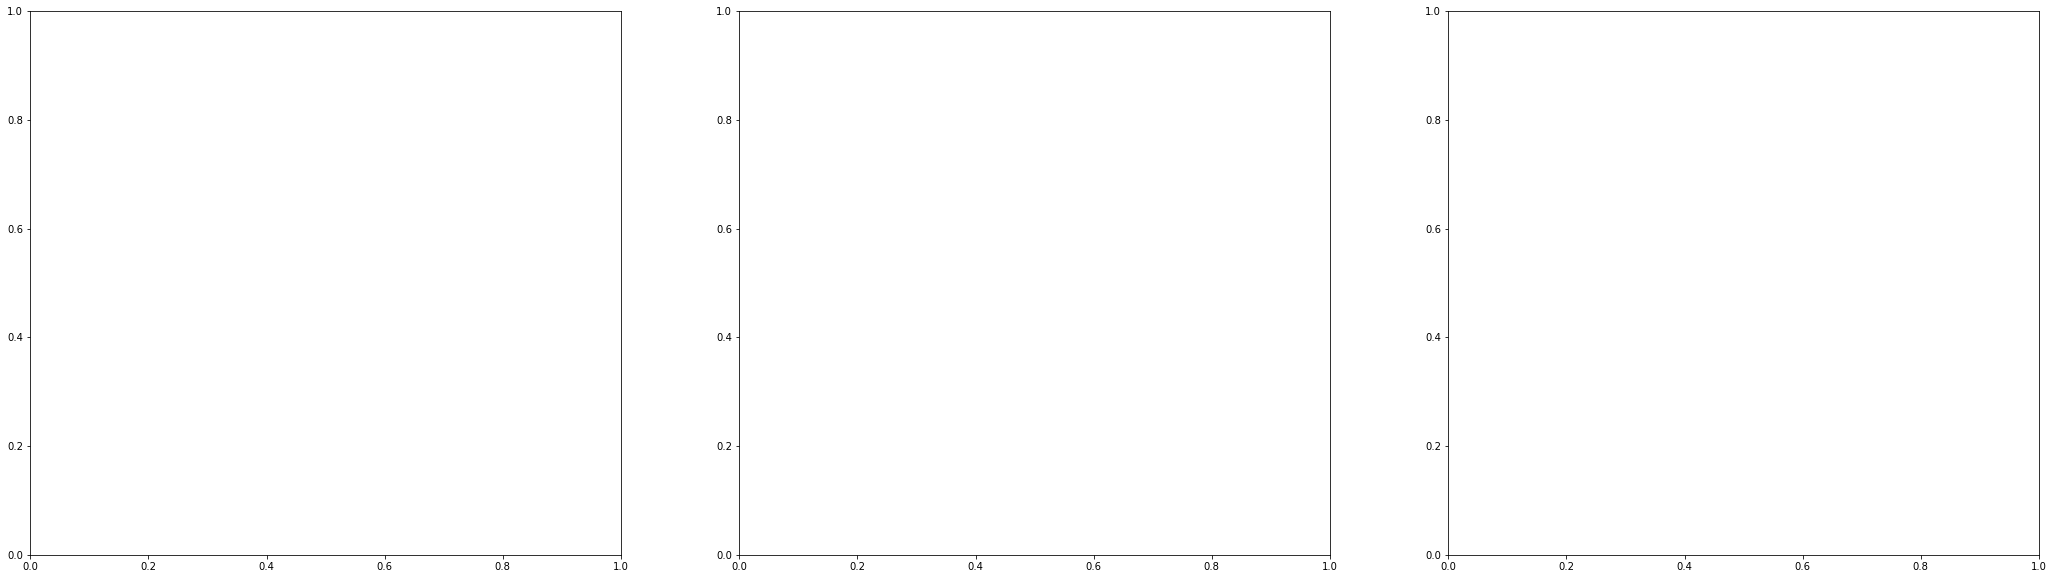

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(36,10),facecolor='white') # prepare our 2x2 grid of subplots in side our figure
cmap_0 = LinearSegmentedColormap.from_list("mycmap", [[1,1,1],[0,0,.5],[0,.5,0],'yellow',[1,0,0],'pink'],N=250)

_ax = axes[0]
sc = _ax.scatter(x_in,y_in,s=1,c=test_data_in,cmap=cmap_0,vmin=0,vmax=.2)
_=plt.colorbar(sc,ax=_ax)
# _ax = axes[0]
# sc = _ax.scatter(x_in,y_in,s=1,c=test_data_in,cmap='RdBu_r',vmin=-.002,vmax=.002)
# _=plt.colorbar(sc,ax=_ax)

_ax = axes[1]
sc = _ax.scatter(x_in,y_in,s=1,c=np.abs(f_reconstructed),cmap=cmap_0,vmin=0,vmax=.2)
plt.colorbar(sc,ax=_ax)
# _ax = axes[1]
# sc = _ax.scatter(x_in,y_in,s=1,c=np.abs(f_reconstructed),cmap='RdBu_r',vmin=-.002,vmax=.002)
# _=plt.colorbar(sc,ax=_ax)

_ax = axes[2]
sc = _ax.scatter(x_in,y_in,s=1,c=f_reconstructed-test_data_in,cmap='RdBu_r',vmin=-.005,vmax=.005)
plt.colorbar(sc,ax=_ax)

In [34]:
kv = (kx_in**2 + ky_in**2) **.5
kv = kv.ravel()
# np.unique(kv)
nbins = int(2e3)
bins = np.linspace(*personal.math.range_bounds(kv),nbins)
mapping = np.digitize(kv,bins)

data_series = pd.Series(data=np.abs((f**1)).ravel(), index=kv)
# data_series = pd.Series(data=np.abs(f.ravel()**2), index=kv)
# test_out = data_series.groupby(data_series.index).apply(np.mean)
test_out = data_series.groupby(mapping).mean()
test_out

/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1       1397.786011
2       1325.135010
3       1193.405884
4       1011.332825
5        803.196289
           ...     
1996       0.235659
1997       0.241820
1998       0.237377
1999       0.225818
2000       0.369787
Length: 2000, dtype: float32

/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


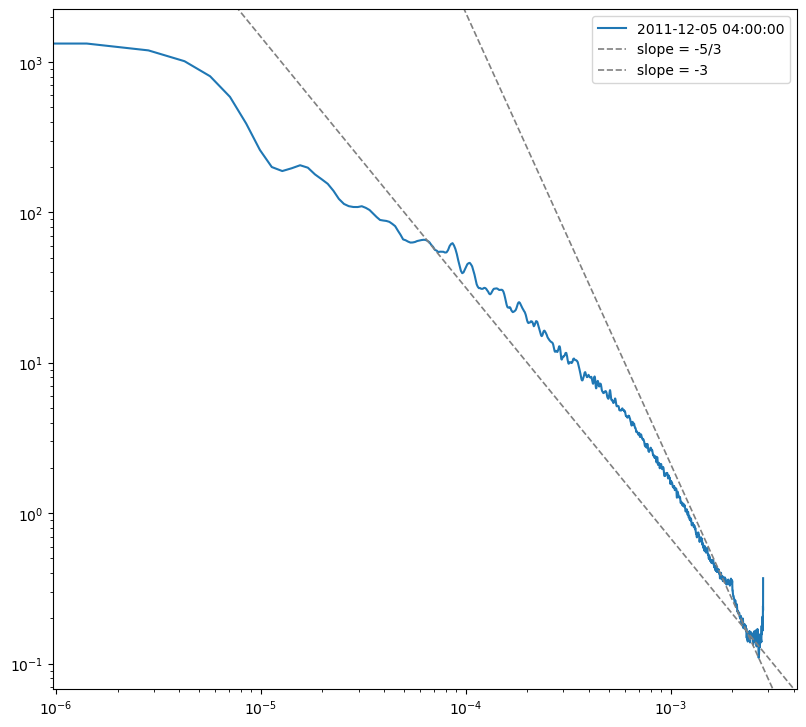

In [100]:
# test_out[::1].plot()
fig,_ax = personal.plots.default_figure(),plt.axes()
x,y = bins, test_out.values
_ax.plot(bins,test_out,label=test_data_struct.time.dt.strftime("%Y-%m-%d %H:%M:%S").values)
plt.yscale('log')
plt.xscale('log')
slope = Fraction(-5,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[x[50],y[50]] , color='gray'    ,linestyle='--',label='slope = ' + str(slope), linewidth=1.2)
slope = Fraction(-9,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[x[-500],y[-500]] , color='gray'    ,linestyle='--',label='slope = ' + str(slope), linewidth=1.2)
_ax.legend()

In [20]:
from IPython.display import HTML
HTML('''<script>
var code_show_err = false; 
var code_toggle_err = function() {
 var stderrNodes = document.querySelectorAll('[data-mime-type="application/vnd.jupyter.stderr"]')
 var stderr = Array.from(stderrNodes)
 if (code_show_err){
     stderr.forEach(ele => ele.style.display = 'block');
 } else {
     stderr.forEach(ele => ele.style.display = 'none');
 }
 code_show_err = !code_show_err
} 
document.addEventListener('DOMContentLoaded', code_toggle_err);
</script>
To toggle on/off output_stderr, click <a onclick="javascript:code_toggle_err()">here</a>.''')

In [21]:
from tqdm.auto import tqdm
from joblib import Parallel, delayed

import logging
logging.captureWarnings(False)

warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore",module='finufft')



inds = {seas:np.random.choice(np.where(seas_groups[seas])[0],size=1000,replace=False) for seas in seas_groups}
inds
# iv   = np.linspace(0,len(KE.time),10)
# iv = [[1,2,3,4,5]]
out = {}


dims={'t':0,'y':1,'x':2}
dx, dy = mpcalc.lat_lon_grid_deltas(KE.lon.values,KE.lat.values) # we havent the degrees east metadata to rely on :/, so gotta load values
dx = np.expand_dims(dx,0)
dy = np.expand_dims(dy,0)
y  = pm.dq_to_q(np.array(dy),dims['y'])[0]
x  = pm.dq_to_q(np.array(dx),dims['x'])[0]
x_in, y_in = x.ravel(), y.ravel()
N = 1000
kmax = 1.5e-3;                  # half the side length in k
# kmax = 2e-3;                  # half the side length in k
dk   = 2*kmax/N;              # spacing of target k grid
k = dk * np.arange(-N/2,(N/2),1);    # a particular uniform M-grid of this spacing
k = dk * np.arange(-N/2,(N/2),1);    # a particular uniform M-grid of this spacing

kx_in, ky_in    = np.meshgrid(k,k)
kx_in, ky_in    = kx_in.astype(np.float32), ky_in.astype(np.float32)
kv = (kx_in**2 + ky_in**2) **.5
kv = kv.ravel()
# nbins = int(N)
nbins = min(200,int(N))
bins = np.linspace(*personal.math.range_bounds(kv),nbins)
mapping = np.digitize(kv,bins)

for i,_inds in inds.items():
    # print(i,':',_inds)
    print(i,'| ', end='')
    test_data_struct = KE['KE'][_inds].sel(baseline='all').compute()
    #
    test_data = test_data_struct.values
    test_data = test_data.reshape(test_data.shape[0],-1)
    Lj = test_data.shape[0]
    test_out = np.full((Lj,len(bins)),np.nan)

#     def parallel_fcn(j,test_out=test_out,test_data=test_data,x_in=x_in,y_in=y_in,dk=dk,k=k,kv=kv,bins=bins,N=N):
#         test_data_in = test_data[j] 
#         valid = ~np.isnan(test_data_in)
#         test_data_in, _x_in, _y_in = test_data_in[valid].astype(np.float32), x_in[valid].astype(np.float32), y_in[valid].astype(np.float32)
#         f = finufft.nufft2d1(dk * _x_in ,dk*_y_in, test_data_in, n_modes=N, eps=1e-12, isign=-1) # 1d type 1 (nonuniform to uniform)
#         # try the same thing with log spacing, and consequently fewer points (type 3, nonuniform to nonuniform :)
#         f_in        = np.real(f)*1 + np.imag(f)*1j
#         data_series = pd.Series(data=np.abs((f**1)).ravel(), index=kv)
#         test_out[j]    = data_series.groupby(mapping).mean().values
#         return     
#     parallel_args  = {'n_jobs':min(3,Lj), 'require':'sharedmem'}
#     Parallel(**parallel_args)(delayed(parallel_fcn)(j) for j in tqdm(range(Lj),total=Lj))

    for j in range(Lj): # naive averaging, dont account for actual amount of data in bins for now...
        test_data_in = test_data[j] 
        valid = ~np.isnan(test_data_in)
        if sum(valid) < 5:
            print(sum(valid))
            continue
        test_data_in, _x_in, _y_in = test_data_in[valid].astype(np.float32), x_in[valid].astype(np.float32), y_in[valid].astype(np.float32)
        f = finufft.nufft2d1(dk * _x_in ,dk*_y_in, test_data_in, n_modes=N, eps=1e-4, isign=-1) # 1d type 1 (nonuniform to uniform)
#         f = finufft.nufft2d3(dk * _x_in ,dk*_y_in, test_data_in, n_modes=N, eps=1e-12, isign=-1) # 1d type 1 (nonuniform to uniform)
        # try the same thing with log spacing, and consequently fewer points (type 3, nonuniform to nonuniform :)
        f_in        = np.real(f)*1 + np.imag(f)*1j
#         data_series = pd.Series(data=np.abs((f**1)).ravel(), index=kv)
#         data_series = pd.Series(data=np.abs(np.imag((f**1))).ravel(), index=kv)
        data_series = pd.Series(data=(np.imag(f)**2).ravel(), index=kv)
        test_out[j]    = data_series.groupby(mapping).mean().values


    test_out = pd.Series(data=np.nanmean(test_out,axis=0),index=np.arange(len(bins)))


    out[i] = (bins, test_out, test_data_struct.time.dt.strftime("%Y-%m-%d %H:%M:%S").values)
output_seas=out

DJF | JFM | FMA | MAM | AMJ | MJJ | JJA | JAS | ASO | SON | OND | NDJ | 

/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


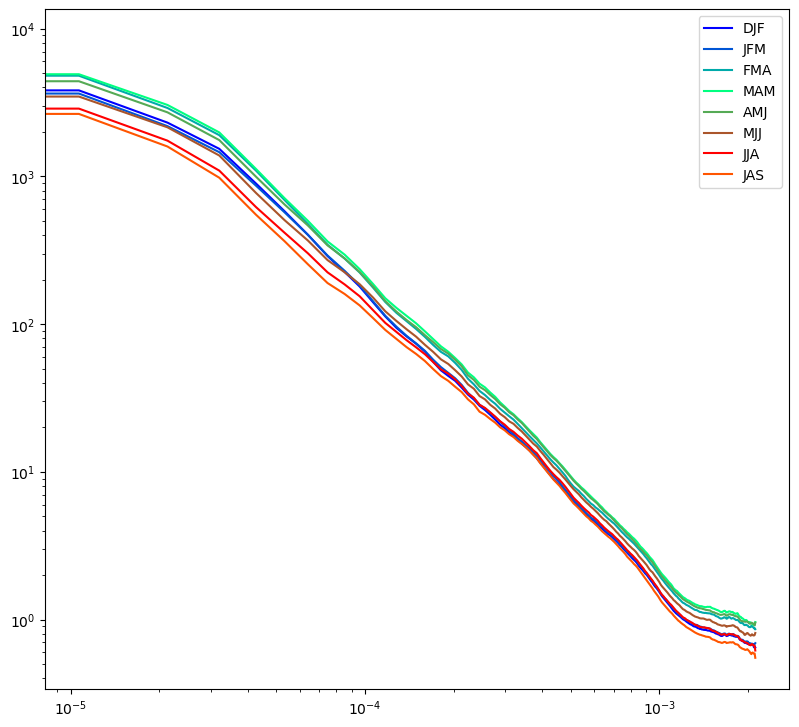

In [16]:
cmap = LinearSegmentedColormap.from_list("mycmap", [[0,0,1],[0,1,.5],[1,0,0],'yellow',[0,0,1]],N=13)
colors = cmap(np.linspace(0, 1, 13)[0:12])
fig,_ax = personal.plots.default_figure(facecolor='white'),plt.axes()
for j,(seas,(bins,test_out,date_str)) in enumerate(out.items()):
    x,y = bins, test_out.values
    _ax.plot(x,y,label=seas,color=colors[j])
    
plt.yscale('log'), plt.xscale('log')
# slope = Fraction(-5,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[x[50],y[50]] , color='gray'    ,linestyle='--',label='slope = ' + str(slope), linewidth=1.2)
# slope = Fraction(-9,3); personal.plots.axline(_ax,slope=float(slope),ax_scale='loglog',intercept=[x[-500],y[-500]] , color='gray'    ,linestyle='--',label='slope = ' + str(slope), linewidth=1.2)
_ax.legend()

/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.0, 1.0)

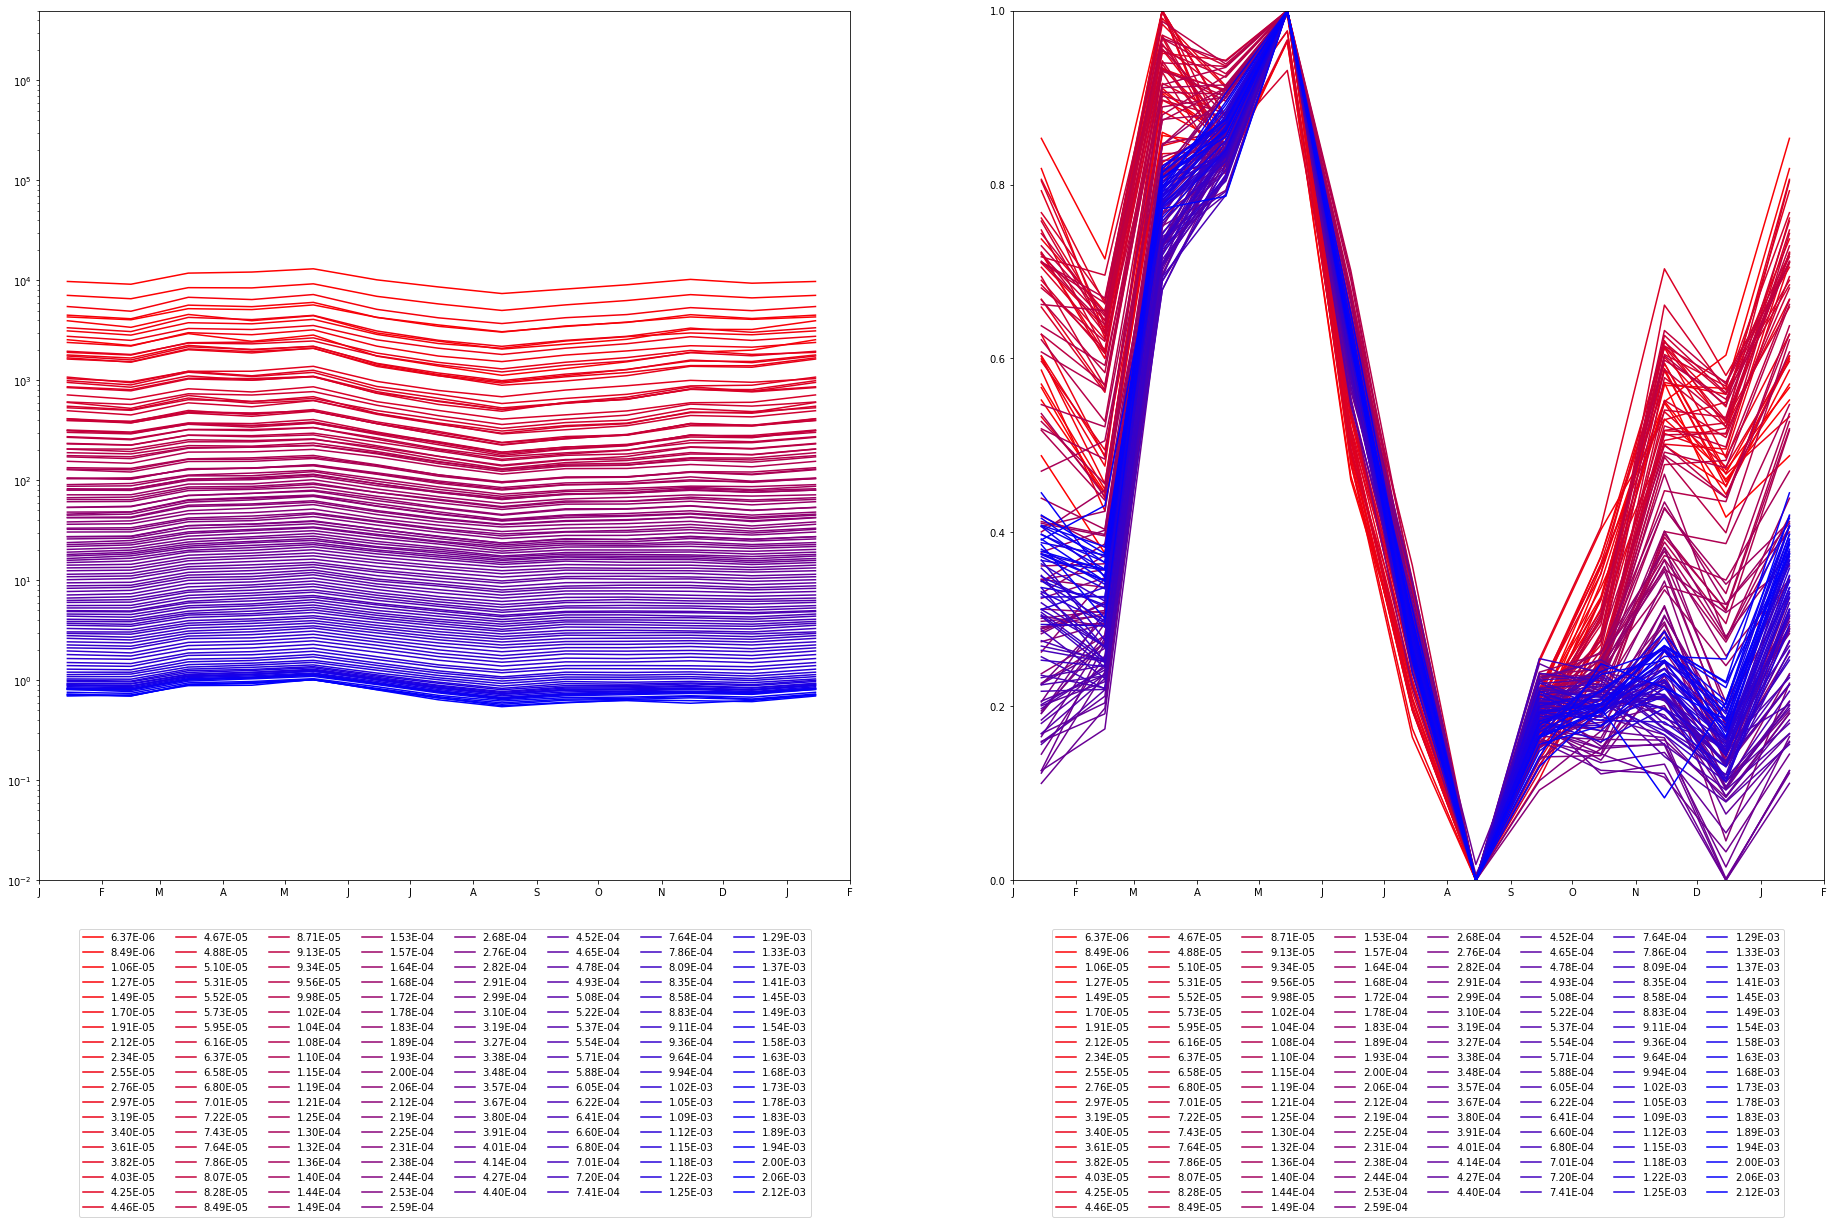

In [17]:
# Plot cycles for various ks

output_timegroups = list(out.keys())

k = output_seas[output_timegroups[0]][0]
k = k[k!=0]
            
peak = 'largest'
if peak == 'earliest': max_ind,max_val = np.inf,-np.inf
if peak == 'largest' : max_ind,max_val = 0     ,-np.inf
for tg in output_timegroups[::+1]:
    _E = output_seas[tg][1].values
    if peak == 'largest':
        mxind = np.argmax(_E)
        mxval = _E[mxind]
        if mxval  > max_val: max_ind,max_val = mxind,mxval # largest peak
    if peak == 'earliest':
        mxind = argrelextrema(_E, np.greater)[0][0]
        mxval = _E[mxind]
        if mxind < max_ind: max_ind,max_val = mxind,mxval # earliest peak
#     print(max_val,max_ind)
    
n = 200
ks = np.geomspace( k[max_ind], k[-1], n)
xt = np.array([np.datetime64(x) for x in dateutil.rrule.rrule(freq=dateutil.rrule.MONTHLY, count=13, dtstart=datetime.datetime(1, 1, 15))])
seas_keys = list(seasons.keys()); seas_keys.append(seas_keys[0]) # repeat end for plot continuity

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(32,16),facecolor='white') # prepare our 2x2 grid of subplots in side our figure
_ax1,_ax2 = axes

for _ax in axes:
    _ax.set_xlim(xmin=np.datetime64('0001-01-01'),xmax=np.datetime64('0002-02-01'))
    _ax.xaxis.set_major_locator(mdates.MonthLocator())
    _ax.xaxis.set_major_formatter( FuncFormatter(lambda x,pos: mdates.DateFormatter('%b')(x)[0] ))

ks_nearest, ksn_inds = personal.data_structures.nearest(ks, k)
ksn_inds,valid       = np.unique(ksn_inds,return_index=True)
ks_nearest           = ks_nearest[valid]

lc = len(ksn_inds)+1
cmap_here   = LinearSegmentedColormap.from_list("mycmap", [[1,0,0],[0,0,1]],N=lc)
colors_here = cmap_here(np.linspace(0, 1, lc)[0:lc-1])
for i,ind in enumerate(ksn_inds):
    E = np.array([output_seas[seas][1].values[ind] for seas in seas_keys])
    E[E<0] = np.nan
    _ax1.plot(xt,E,color = colors_here[i], label=f"{k[ind]:.2E}" )
    E_norm = sklearn.preprocessing.minmax_scale(np.log10(E),feature_range=(0,1),copy=True)
    _ax2.plot(xt,E_norm,color = colors_here[i], label=f"{k[ind]:.2E}" )

leg1,leg2 = _ax1.legend(loc='upper center',ncol=8, bbox_to_anchor=(.5, -0.05)), _ax2.legend(loc='upper center',ncol=8, bbox_to_anchor=(.5, -0.05))
_ax1.set_yscale('log')   ; _ax1.set_ylim([1e-2, 5.0e6]);
_ax2.set_yscale('linear'); _ax2.set_ylim([0,1])

In [45]:
np.diff(personal.math.range_bounds(x))

array([70.99])

In [138]:
import numpy as np
from pynufft import NUFFT, helper
L = int(1e4)
# x = np.linspace(-50,50,L)
x = (np.random.rand(L,1)-.5)*100
data = 100*np.sin(1/np.pi *x) + 50*np.sin(2 * x)   - 30*np.cos(4*x ) + 0j 
scale = (2*np.pi) / np.diff(personal.math.range_bounds(x))
xscl  = x * scale # You have to scale your data to be within these bounds...
shft  = np.pi - np.max(xscl) 
xsclshft = xscl + shft

# restore_time  = A.solve(data,'cg'     , maxiter=30)

In [145]:
# Prepare the NUDFT
A = NUFFT()
om = x
# om = np.linspace(np.min(xsclshft),np.max(xsclshft),4L)
om = np.atleast_2d(om).T
print(om.shape)
print(om.shape)
Nd = (L//L,)
Kd = (L//5*2,)
Jd = (6,)
A.plan(om, Nd, Kd, Jd)

# Plot the data
plt.figure(figsize=(25,5))
plt.scatter(xsclshft,data)
plt.show()

# Do the NUDFT and plot it
plt.figure(figsize=(25,5))
nufft_freq_data = A.forward(data)
print(len(nufft_freq_data))
kscale = 1 # <-- what is this scale supposed to be, or is it a fcn? The positions of the peaks seem to change with the length of x which doesn't match a real fft...
k = np.linspace(-np.pi,np.pi,Nd[0])  * kscale 
plt.scatter(k, nufft_freq_data.imag, 5,  label='imag',color='b')
plt.scatter(k, nufft_freq_data.real, 5, label='real',color='r')
plt.xticks(np.arange(np.round(min(k)), np.round(max(k)+1), 2))
plt.legend()
plt.show()

# restore signal (works ok ish)
restore_time  = A.solve(nufft_freq_data,'cg'     , maxiter=30)  / scale
restore_time2 = A.solve(nufft_freq_data,'L1TVOLS', maxiter=30,rho=1) / scale
plt.figure(figsize=(25,5))
# im1=plt.scatter(x, data    ,15,color='r' , marker='o' ,label='original signal')
im3=plt.scatter((xsclshft-shft)/scale, restore_time2,10,color='k' , marker='1' ,label='L1TVOLS')
im4=plt.scatter((xsclshft-shft)/scale, restore_time ,5,color='b'  , marker="X" ,label='conjugate_gradient_method')
plt.ylim([-15,15])
plt.legend()
plt.show()

In [210]:
np.angle(restore_time2**1)

array([-1.5486041 ,  1.5823237 , -1.5744507 ,  1.5699288 , -1.5731871 ,
        1.5663596 , -1.5854164 ,  1.5624993 , -1.578837  ,  1.5552301 ,
       -1.5832309 ,  1.5658436 , -1.569941  ,  1.5928664 , -1.5591811 ,
        1.5970019 , -1.557216  ,  1.591167  , -1.569096  ,  1.5786324 ,
       -1.5586803 ,  1.5608084 , -1.5776422 ,  1.5499089 , -1.5975388 ,
        1.5520053 , -1.5877724 ,  1.5561    , -1.5820137 ,  1.550976  ,
       -1.5810184 ,  1.5687423 , -1.5835901 ,  1.5680273 , -1.5784929 ,
        1.5664526 , -1.5806142 ,  1.5558207 , -1.5852449 ,  1.5515798 ,
       -1.5959747 ,  1.5421206 , -1.5946292 ,  1.5564958 , -1.5937532 ,
        1.5533335 , -1.5784035 ,  1.5614474 , -1.5850195 ,  1.5660651 ,
       -1.5827799 ,  1.562247  , -1.5910306 ,  1.5706565 , -1.566421  ,
        1.5852413 , -1.5476973 ,  1.5931721 , -1.5474519 ,  1.5952085 ,
       -1.5413731 ,  1.6016823 , -1.5391425 ,  1.6061782 , -1.5393004 ,
        1.604028  , -1.5283422 ,  1.6060222 , -1.524403  ,  1.61

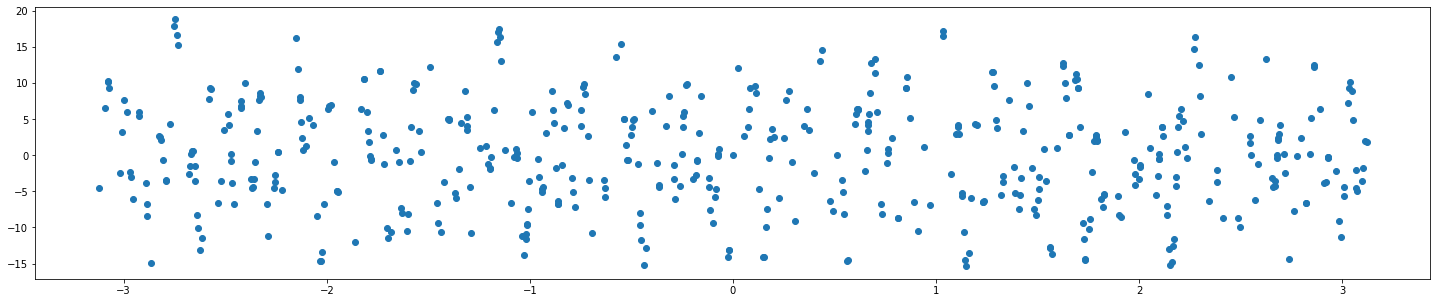

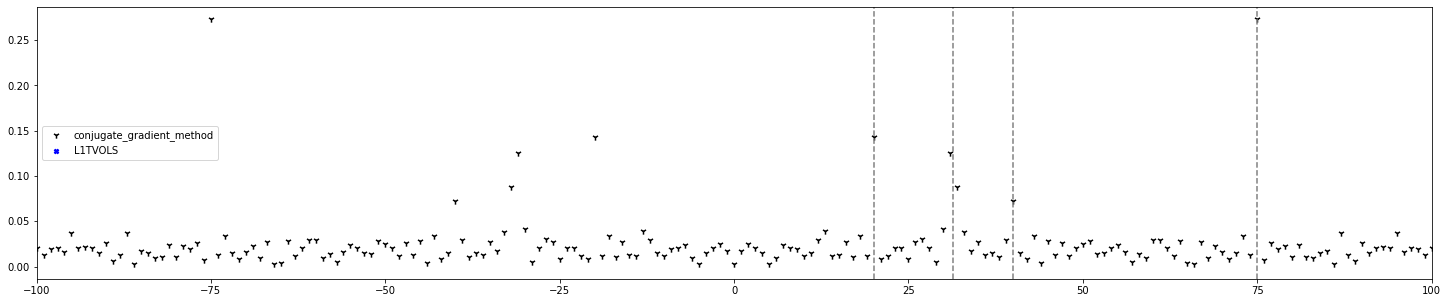

In [303]:
L = int(5e2)
x = (np.random.rand(L,1)-.5)*2 * np.pi
# the real data in x (k) space, that would have come out of the forward transform at points om, of any shape, scaled between [-np.pi and np.pi]
data =  0j \
        + 5*np.cos(10*np.pi *x - np.pi/2) \
        + 4*np.sin(20 * x) \
        - 2*np.cos(40*x )  \
        + 8*np.sin(75*x) \


B = NUFFT()
Nd = (10000,) # the dimensions of the grid and oversampled grid in k (x) space
Kd = (Nd[0]*2,)
B.plan(x, Nd , Kd, Jd)


# Plot the data
plt.figure(figsize=(25,5))
plt.scatter(x,data)
plt.show()


# restore signal (works ok ish)
restore_time  = B.solve(data ,'cg'     , maxiter=1000)       
restore_time2 = B.solve(data ,'L1TVOLS', maxiter=100,rho=1) # is more unstable, might go to nan and not plot

# ------------------- How do I perform the normalization here, so the plots below come out correct? ----------------- #

plt.figure(figsize=(25,5))
ax = plt.axes()
ax.axvline(10*np.pi, linestyle='--',color='gray')
ax.axvline(20      , linestyle='--',color='gray')
ax.axvline(40      , linestyle='--',color='gray')
ax.axvline(75      , linestyle='--',color='gray')

k = np.arange(Nd[0]) - Nd[0]/2
im3=plt.scatter(k, np.abs(restore_time**1),40,color='k' , marker='1' ,label='conjugate_gradient_method')
# im3=plt.scatter(k, np.angle(restore_time**1),10,color='k' , marker='1' ,label='conjugate_gradient_method') # phase would be nice to know but for E spectra will only need the amplitude :) 

im4=plt.scatter(k, np.abs(restore_time2**1) ,20 ,color='b' , marker="X" ,label='L1TVOLS')
# im3=plt.scatter(k, np.angle(restore_time2**1),10,color='b' , marker='1' ,label='L1TVOLS')

ax.set_xlim([-100,100])
plt.legend()
plt.show()